### GPU, cuda, gccの確認


In [ ]:
!nvidia-smi
!nvcc --version
!gcc --version

### パッケージのインストール / クリーンインストール
ssh先のjupyter環境などで実行の場合は, 当該環境にパッケージをインストール

In [ ]:
# クリーンが必要であれば実行
!rm -rf kineticEQ
#!rm -rf build

In [ ]:
# インストール
!git clone https://github.com/Minamium/kineticEQ.git
!pip install -e ./kineticEQ

### 動作確認

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
import math

from kineticEQ import BGK2D2V_core

# =========================
# 1. シミュレーション設定
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

nx, ny   = 256, 128       # x を細かく、y は薄い 1D っぽく
nv_x, nv_y = 32, 32

Lx, Ly   = 1.0, 0.125    # y は薄いスラブ
vx_max, vy_max = 6.0, 6.0

dt       = 5e-6
T_total  = 0.05           # 衝撃波が十分発展するまで（あとで調整）
tau_tilde = 5e-5         # 粘性小さめ（やりすぎると硬くなるので注意）

# 格子点座標
x = torch.linspace(0.0, Lx, nx)
y = torch.linspace(0.0, Ly, ny)
X, Y = torch.meshgrid(x, y, indexing="ij")

# 初期値配列
n0   = torch.zeros((nx, ny))
u_x0 = torch.zeros((nx, ny))
u_y0 = torch.zeros((nx, ny))
T0   = torch.zeros((nx, ny))

# Riemann 問題の左右状態
n_L, T_L, ux_L = 1.0,   1.0, 0.0
n_R, T_R, ux_R = 0.125, 0.8, 0.0

x_mid = 0.5 * Lx
mask_L = (X <= x_mid)
mask_R = ~mask_L

n0[mask_L]   = n_L
T0[mask_L]   = T_L
u_x0[mask_L] = ux_L

n0[mask_R]   = n_R
T0[mask_R]   = T_R
u_x0[mask_R] = ux_R

# u_y は 0 のままでよい

# =========================
# 2. インスタンス生成 & 実行
# =========================
bgk = BGK2D2V_core(
    nx=nx,
    ny=ny,
    nv_x=nv_x,
    nv_y=nv_y,
    dt=dt,
    T_total=T_total,
    Lx=Lx,
    Ly=Ly,
    vx_max=vx_max,
    vy_max=vy_max,
    tau_tilde=tau_tilde,
    n=n0,
    u_x=u_x0,
    u_y=u_y0,
    T=T0,
    device=device,
    dtype="float64",
    use_tqdm=True,
    flag_record_state=True,
    explicit_advection_scheme="MUSCL2",
    # 将来的に x 方向を非周期にしたいなら
    # bc_x_min="neumann", bc_x_max="neumann", などに差し替え

    explicit_kernel="backend"
)

bgk.run_simulation()
states = bgk.animation_data
print(f"Recorded frames: {len(states)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

# =========================
# 3. 前処理：スケールと渦度の計算
# =========================

# 各物理量の全フレームをスタックして min / max を取る
n_all  = np.stack([s["n"]   for s in states], axis=0)   # (Nt, nx, ny)
ux_all = np.stack([s["u_x"] for s in states], axis=0)
uy_all = np.stack([s["u_y"] for s in states], axis=0)
T_all  = np.stack([s["T"]   for s in states], axis=0)

n_min, n_max = n_all.min(), n_all.max()
T_min, T_max = T_all.min(), T_all.max()

Ux_max = np.abs(ux_all).max()
Uy_max = np.abs(uy_all).max()

# 渦度 ω = ∂x u_y - ∂y u_x を全フレームで計算（周期境界前提の中央差分）
dx, dy = bgk.dx, bgk.dy

omega_list = []
for s in states:
    ux = s["u_x"]
    uy = s["u_y"]

    dudy_dx = (np.roll(uy, -1, axis=0) - np.roll(uy, 1, axis=0)) / (2.0 * dx)
    dux_dy  = (np.roll(ux, -1, axis=1) - np.roll(ux, 1, axis=1)) / (2.0 * dy)

    omega = dudy_dx - dux_dy
    s["omega"] = omega            # 各フレームに渦度を保存しておく
    omega_list.append(omega)

omega_all = np.stack(omega_list, axis=0)
W_max = np.abs(omega_all).max()

# 速度の大きさ |u| も可視化用に最大値を取っておく
Umag_all = np.sqrt(ux_all**2 + uy_all**2)
Umag_max = Umag_all.max()

# =========================
# 4. アニメーション (GIF) 作成
# =========================

Lx, Ly = bgk.Lx, bgk.Ly

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
(ax_n, ax_T, ax_umag), (ax_ux, ax_uy, ax_w) = axes

frame0 = states[0]
nx0, ny0 = frame0["n"].shape

# 初期フレームから |u| を計算
umag0 = np.sqrt(frame0["u_x"]**2 + frame0["u_y"]**2)

# --- Density ---
n_img = ax_n.imshow(
    frame0["n"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=n_min, vmax=n_max,
    cmap="viridis"
)
ax_n.set_title("Density n")
cbar_n = fig.colorbar(n_img, ax=ax_n, fraction=0.046, pad=0.04)
cbar_n.set_label("n")

# --- Temperature ---
T_img = ax_T.imshow(
    frame0["T"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=T_min, vmax=T_max,
    cmap="viridis"
)
ax_T.set_title("Temperature T")
cbar_T = fig.colorbar(T_img, ax=ax_T, fraction=0.046, pad=0.04)
cbar_T.set_label("T")

# --- |u| ---
umag_img = ax_umag.imshow(
    umag0.T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=0.0, vmax=Umag_max,
    cmap="magma"
)
ax_umag.set_title("|u|")
cbar_umag = fig.colorbar(umag_img, ax=ax_umag, fraction=0.046, pad=0.04)
cbar_umag.set_label("|u|")

# --- u_x ---
ux_img = ax_ux.imshow(
    frame0["u_x"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=-Ux_max, vmax=Ux_max,
    cmap="RdBu_r"
)
ax_ux.set_title("u_x")
cbar_ux = fig.colorbar(ux_img, ax=ax_ux, fraction=0.046, pad=0.04)
cbar_ux.set_label("u_x")

# --- u_y ---
uy_img = ax_uy.imshow(
    frame0["u_y"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=-Uy_max, vmax=Uy_max,
    cmap="RdBu_r"
)
ax_uy.set_title("u_y")
cbar_uy = fig.colorbar(uy_img, ax=ax_uy, fraction=0.046, pad=0.04)
cbar_uy.set_label("u_y")

# --- vorticity ω ---
w_img = ax_w.imshow(
    frame0["omega"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=-W_max, vmax=W_max,
    cmap="RdBu_r"
)
ax_w.set_title("vorticity ω")
cbar_w = fig.colorbar(w_img, ax=ax_w, fraction=0.046, pad=0.04)
cbar_w.set_label("ω")

for ax in axes.ravel():
    ax.set_xlabel("x")
    ax.set_ylabel("y")

fig.tight_layout()

def update(frame_idx):
    state = states[frame_idx]

    umag = np.sqrt(state["u_x"]**2 + state["u_y"]**2)

    n_img.set_data(state["n"].T)
    T_img.set_data(state["T"].T)
    umag_img.set_data(umag.T)
    ux_img.set_data(state["u_x"].T)
    uy_img.set_data(state["u_y"].T)
    w_img.set_data(state["omega"].T)

    fig.suptitle(f"t = {state['time']:.3f}")
    return [n_img, T_img, umag_img, ux_img, uy_img, w_img]

anim = animation.FuncAnimation(
    fig,
    update,
    frames=len(states),
    interval=100,  # 1フレーム 100 ms
    blit=False,
)

gif_name = "bgk2d2v_moments_vorticity.gif"
anim.save(gif_name, writer=animation.PillowWriter(fps=10))
plt.close(fig)

Image(filename=gif_name)


In [1]:
import torch
import numpy as np
import math
from kineticEQ import BGK2D2V_core

# =========================
# 1. シミュレーション設定
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

nx, ny   = 256, 256       # 正方形領域
nv_x, nv_y = 32, 32       # 速度空間はほどほど

Lx, Ly   = 1.0, 1.0
vx_max, vy_max = 5.0, 5.0

dt       = 5e-5           # CFL ~ 0.125 程度
T_total  = 5.0            # KH のロールアップが見える程度まで
tau_tilde = 1e-4          # そこそこレイノルズ数が高い設定

# 格子点座標
x = torch.linspace(0.0, Lx, nx)
y = torch.linspace(0.0, Ly, ny)
X, Y = torch.meshgrid(x, y, indexing="ij")

# 密度・温度は一様
n0 = torch.ones((nx, ny))
T0 = torch.ones((nx, ny))

# =========================
# 2. Double shear layer 初期条件
# =========================

U0    = 0.5          # 代表速度
delta = 0.05 * Ly    # せん断層の厚さ（かなり薄めにして KH を強める）

u_x0 = torch.zeros_like(X)

# 下側せん断層（y ≈ 0.25）
mask_lower = (Y <= 0.5 * Ly)
u_x0[mask_lower] = U0 * torch.tanh((Y[mask_lower] - 0.25 * Ly) / delta)

# 上側せん断層（y ≈ 0.75）
mask_upper = ~mask_lower
u_x0[mask_upper] = -U0 * torch.tanh((Y[mask_upper] - 0.75 * Ly) / delta)
# 上下で逆向きの流れにして shear を強める

# --- y方向擾乱 u_y(x,y) ---
eps   = 0.1 * U0             # 擾乱振幅（あまり大きくしすぎない）
k_x   = 2.0 * math.pi / Lx   # x 方向基本波 1 波長
sigma = 0.05 * Ly            # せん断層近傍に局在させる幅

perturb = eps * torch.sin(k_x * X) * (
    torch.exp(-((Y - 0.25 * Ly)**2) / (2.0 * sigma**2)) +
    torch.exp(-((Y - 0.75 * Ly)**2) / (2.0 * sigma**2))
)

u_y0 = perturb

# =========================
# 3. BGK2D2V インスタンス生成 & 実行
# =========================
bgk = BGK2D2V_core(
    nx=nx,
    ny=ny,
    nv_x=nv_x,
    nv_y=nv_y,
    dt=dt,
    T_total=T_total,
    Lx=Lx,
    Ly=Ly,
    vx_max=vx_max,
    vy_max=vy_max,
    tau_tilde=tau_tilde,
    n=n0,
    u_x=u_x0,
    u_y=u_y0,
    T=T0,
    device=device,
    dtype="float64",
    use_tqdm=True,
    flag_record_state=True,
    explicit_advection_scheme="MUSCL2",
    # KH では x, y とも周期境界が自然なのでデフォルトの periodic のままで OK
    explicit_kernel="backend"
)

bgk.run_simulation()
states = bgk.animation_data
print(f"Recorded frames: {len(states)}")


  nx=256, ny=256, nv_x=32, nv_y=32
  dx=0.00390625, dy=0.00390625, dv_x=0.3125, dv_y=0.3125
  dt=5e-05, T_total=5.0, nt=100000
  tau_tilde=0.0001
  explicit_advection_scheme=MUSCL2
  BC x_min=periodic, x_max=periodic, y_min=periodic, y_max=periodic
  dtype: float64
  device: cuda, GPU name: NVIDIA A30, Total memory: 23.60 GB
--- compile CUDA fused explicit backend ---


NoneType: None


ninja: no work to do.
--- fused CUDA backend loaded ---
 --- Array allocation ---
 --- Initialize fields ---
  CFL numbers: Cx=0.064000, Cy=0.064000, Cx+Cy=0.128000
  CFL condition satisfied.
 --- run simulation ---


Explicit Evolution: 100%|██████████| 100000/100000 [12:03<00:00, 138.27it/s]

--- run simulation complete, Result is saved in self.f, self.u_x, self.u_y, self.T ---
Recorded frames: 51


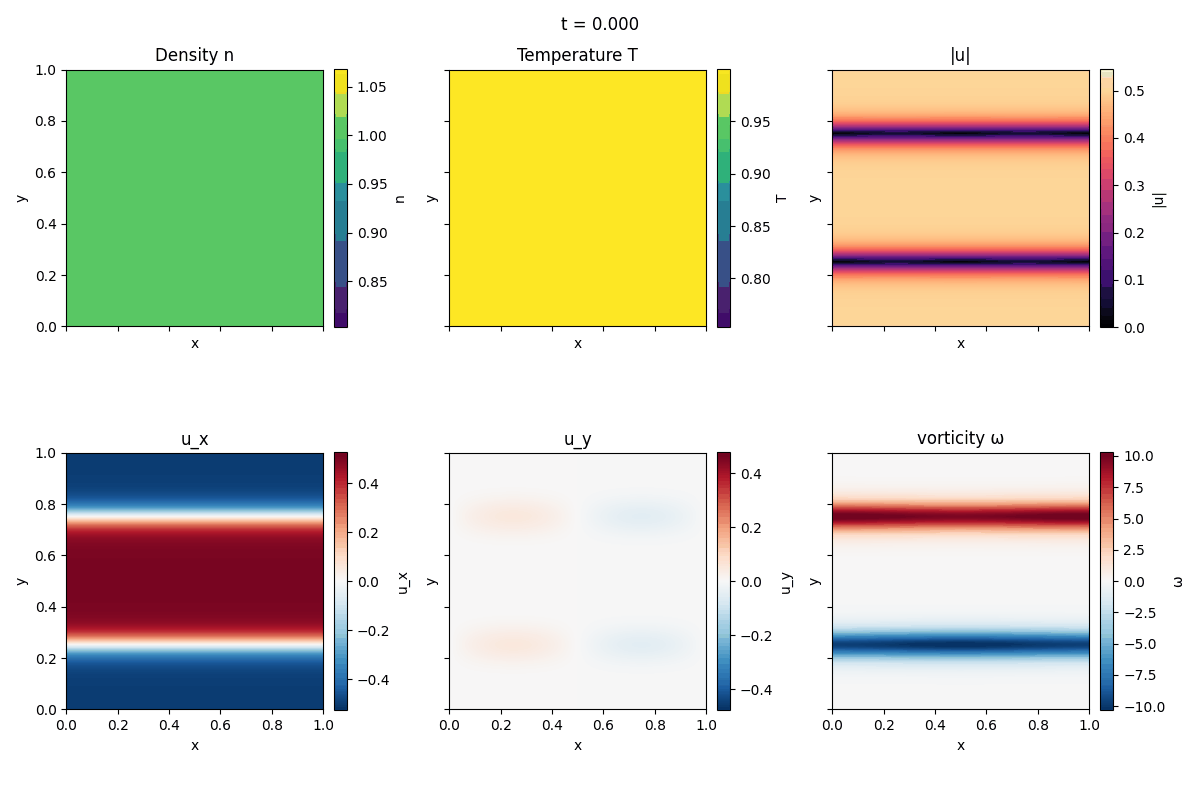

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

# =========================
# 渦度・スケールの前処理
# =========================

n_all  = np.stack([s["n"]   for s in states], axis=0)
ux_all = np.stack([s["u_x"] for s in states], axis=0)
uy_all = np.stack([s["u_y"] for s in states], axis=0)
T_all  = np.stack([s["T"]   for s in states], axis=0)

n_min, n_max = n_all.min(), n_all.max()
T_min, T_max = T_all.min(), T_all.max()

Ux_max = np.abs(ux_all).max()
Uy_max = np.abs(uy_all).max()

dx, dy = bgk.dx, bgk.dy

omega_list = []
for s in states:
    ux = s["u_x"]
    uy = s["u_y"]

    dudy_dx = (np.roll(uy, -1, axis=0) - np.roll(uy, 1, axis=0)) / (2.0 * dx)
    dux_dy  = (np.roll(ux, -1, axis=1) - np.roll(ux, 1, axis=1)) / (2.0 * dy)
    omega = dudy_dx - dux_dy

    s["omega"] = omega
    omega_list.append(omega)

omega_all = np.stack(omega_list, axis=0)
W_max = np.abs(omega_all).max()

Umag_all = np.sqrt(ux_all**2 + uy_all**2)
Umag_max = Umag_all.max()

# =========================
# アニメーション作成
# =========================

Lx, Ly = bgk.Lx, bgk.Ly

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
(ax_n, ax_T, ax_umag), (ax_ux, ax_uy, ax_w) = axes

frame0 = states[0]
umag0 = np.sqrt(frame0["u_x"]**2 + frame0["u_y"]**2)

# Density
n_img = ax_n.imshow(
    frame0["n"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=n_min, vmax=n_max,
    cmap="viridis"
)
ax_n.set_title("Density n")
cbar_n = fig.colorbar(n_img, ax=ax_n, fraction=0.046, pad=0.04)
cbar_n.set_label("n")

# Temperature
T_img = ax_T.imshow(
    frame0["T"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=T_min, vmax=T_max,
    cmap="viridis"
)
ax_T.set_title("Temperature T")
cbar_T = fig.colorbar(T_img, ax=ax_T, fraction=0.046, pad=0.04)
cbar_T.set_label("T")

# |u|
umag_img = ax_umag.imshow(
    umag0.T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=0.0, vmax=Umag_max,
    cmap="magma"
)
ax_umag.set_title("|u|")
cbar_umag = fig.colorbar(umag_img, ax=ax_umag, fraction=0.046, pad=0.04)
cbar_umag.set_label("|u|")

# u_x
ux_img = ax_ux.imshow(
    frame0["u_x"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=-Ux_max, vmax=Ux_max,
    cmap="RdBu_r"
)
ax_ux.set_title("u_x")
cbar_ux = fig.colorbar(ux_img, ax=ax_ux, fraction=0.046, pad=0.04)
cbar_ux.set_label("u_x")

# u_y
uy_img = ax_uy.imshow(
    frame0["u_y"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=-Uy_max, vmax=Uy_max,
    cmap="RdBu_r"
)
ax_uy.set_title("u_y")
cbar_uy = fig.colorbar(uy_img, ax=ax_uy, fraction=0.046, pad=0.04)
cbar_uy.set_label("u_y")

# vorticity ω
w_img = ax_w.imshow(
    frame0["omega"].T,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    vmin=-W_max, vmax=W_max,
    cmap="RdBu_r"
)
ax_w.set_title("vorticity ω")
cbar_w = fig.colorbar(w_img, ax=ax_w, fraction=0.046, pad=0.04)
cbar_w.set_label("ω")

for ax in axes.ravel():
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")   # KH は aspect=1 の方が渦構造が見やすい

fig.tight_layout()

def update(frame_idx):
    state = states[frame_idx]
    umag = np.sqrt(state["u_x"]**2 + state["u_y"]**2)

    n_img.set_data(state["n"].T)
    T_img.set_data(state["T"].T)
    umag_img.set_data(umag.T)
    ux_img.set_data(state["u_x"].T)
    uy_img.set_data(state["u_y"].T)
    w_img.set_data(state["omega"].T)

    fig.suptitle(f"t = {state['time']:.3f}")
    return [n_img, T_img, umag_img, ux_img, uy_img, w_img]

anim = animation.FuncAnimation(
    fig,
    update,
    frames=len(states),
    interval=100,
    blit=False,
)

gif_name = "bgk2d2v_KH_vorticity.gif"
anim.save(gif_name, writer=animation.PillowWriter(fps=10))
plt.close(fig)

Image(filename=gif_name)
